# Predykcja słowa występującego po danej sekwencji z wykorzystaniem modelu LSTM

Celem projektu jest predykcja słowa następującego po sekwencji składającej się z określonej liczby słów. Do tego zagadnienia wykorzystano zestaw ok. 2500 cytatów o długości od kilku do kilkunastu słów.

### Importowanie niezbędnych bibliotek

In [1]:
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

### Budowa modelu i zdefiniowanie jego parametrów

W projekcie do predykcji następnego słowa zastosowano model LSTM (Long Short-Term Memory). Jest to rodzaj rekurencyjnej sieci neuronowej zaprojektowanej w celu rozwiązania probelmu zanikającego gradientu występującego podczas treningu tradycyjnych sieci neuronowych. Przewagą tego modelu jest zapewnienie krótkoterminowej pamięci przez długi okres, stąd jego nazwa. Wykorzystuje się go w zadaniach klasyfikacyjnych, przetwarzaniu i prognozowaniu danych opartych na szeregach czasowych, rozpoznawania mowy czy tłumaczenia tekstu na inny język.

Na architekturę modelu LSTM składają się 3 główne komponenty - brama wejściowa, brama zapominająca oraz brama wyjściowa. Brama wejściowa podejmuje decyzje o tym, które wartości na wejściu są ważne i powinny zostać przepuszczone przez model. W tym miejscu używana jest funkcja sigmoidalna, która określa, które wartości należy przekazać przez sieć rekurencyjną. Po uwzględnieniu bieżących wejść i stanu pamięci bramka wyjściowa decyduje, które wartości należy przekazać do następnego kroku czasowego. W bramce wyjściowej wartości są analizowane i przypisuje się im wagę w zakresie od -1 do 1. Zadaniem bramki zapominanającej z kolei jest usunięcie informacji, które model uważa za niepotrzebne do podjęcia decyzji o charakterze wartości wejściowych. Bramka zapominania wykorzystuje funkcję sigmoidalną na wartościach, wypisując liczby od 0 (zapomnij o tym) do 1 (zachowaj to).

In [7]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embedded = self.embedding(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(embedded, (h_0, c_0))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [2]:
path = './next_word_prediction_dataset.csv'
sequence_length = 10
train_size = 0.9
batch_size = 32
embedding_dim = 32
hidden_dim = 512
num_layers = 2
learning_rate = 0.0001
num_epochs = 30

### Preprocessing danych

Poniższa funkcja `load_and_preprocess_text` wczytuje plik z cytatami, dzieli tekst na tokeny, oczyszcza go, a następnie każdemu tokenowi zostaje nadany unikalny indeks.

In [3]:
def load_and_preprocess_text(path, sequence_length):
    with open(path, mode = 'r', encoding = 'UTF-8') as f:
        text = f.read()
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    words = text.split()
    unique_tokens = sorted(set(words))
    word_to_idx = {word: i for i, word in enumerate(unique_tokens)}
    word_indices = [word_to_idx[word] for word in words]
    sequences = []
    for i in range(len(word_indices) - sequence_length):
        seq = word_indices[i:i + sequence_length]
        target = word_indices[i + sequence_length]
        sequences.append((seq, target))
    vocab_size = len(word_to_idx)
    return sequences, vocab_size, word_to_idx

In [4]:
sequences, vocab_size, word_to_idx = load_and_preprocess_text(path, sequence_length)

Funkcja `create_dataset` dzieli podane sekwencje słów na zbiory treningowy oraz testowy z najczęściej stosowanym w uczeniu maszynowym tzw. ziarnem losowości wynoszącym 42. Następnie sekwencje zostają przekonwertowane na tensory oraz tensorowe obiekty DataLoader służące do ładowania danch w formie batchy o zadanym rozmiarze poprzez parametr `batch_size` do modelu.

In [5]:
def create_dataset(sequences, train_size, batch_size):
    seq_train, seq_test = train_test_split(sequences, train_size = train_size, random_state = 42)
    X_train = [seq for seq, _ in seq_train]
    y_train = [target for _, target in seq_train]
    X_test = [seq for seq, _ in seq_test]
    y_test = [target for _, target in seq_test]
    X_train_tensor = torch.tensor(X_train, dtype = torch.long)
    y_train_tensor = torch.tensor(y_train, dtype = torch.long)
    X_test_tensor = torch.tensor(X_test, dtype = torch.long)
    y_test_tensor = torch.tensor(y_test, dtype = torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
    return train_loader, test_loader

In [6]:
train_loader, test_loader = create_dataset(sequences, train_size, batch_size)

### Inicjalizacja modelu

In [8]:
model = Model(vocab_size, embedding_dim, hidden_dim, num_layers, vocab_size)

### Trening

In [9]:
def train_model(model, learning_rate, num_epochs, train_loader):
    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_losses = []
    train_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == y).sum().item()
            total_samples += y.size(0)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_predictions / total_samples
        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {round(avg_train_loss, 2)}, Train Accuracy: {round(train_accuracy * 100, 2)}%')
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
    plt.figure(figsize = (16, 9))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label = 'Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(axis = 'y')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label = 'Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(axis = 'y')
    plt.show()

Epoch [1/30], Train Loss: 5.22, Train Accuracy: 14.0%
Epoch [2/30], Train Loss: 4.25, Train Accuracy: 27.13%
Epoch [3/30], Train Loss: 3.69, Train Accuracy: 34.06%
Epoch [4/30], Train Loss: 3.29, Train Accuracy: 38.12%
Epoch [5/30], Train Loss: 2.97, Train Accuracy: 42.49%
Epoch [6/30], Train Loss: 2.7, Train Accuracy: 46.14%
Epoch [7/30], Train Loss: 2.46, Train Accuracy: 50.05%
Epoch [8/30], Train Loss: 2.25, Train Accuracy: 53.45%
Epoch [9/30], Train Loss: 2.05, Train Accuracy: 56.83%
Epoch [10/30], Train Loss: 1.87, Train Accuracy: 60.43%
Epoch [11/30], Train Loss: 1.71, Train Accuracy: 63.45%
Epoch [12/30], Train Loss: 1.55, Train Accuracy: 66.61%
Epoch [13/30], Train Loss: 1.41, Train Accuracy: 69.33%
Epoch [14/30], Train Loss: 1.27, Train Accuracy: 72.39%
Epoch [15/30], Train Loss: 1.15, Train Accuracy: 75.22%
Epoch [16/30], Train Loss: 1.03, Train Accuracy: 77.77%
Epoch [17/30], Train Loss: 0.92, Train Accuracy: 80.41%
Epoch [18/30], Train Loss: 0.82, Train Accuracy: 82.86%
Epo

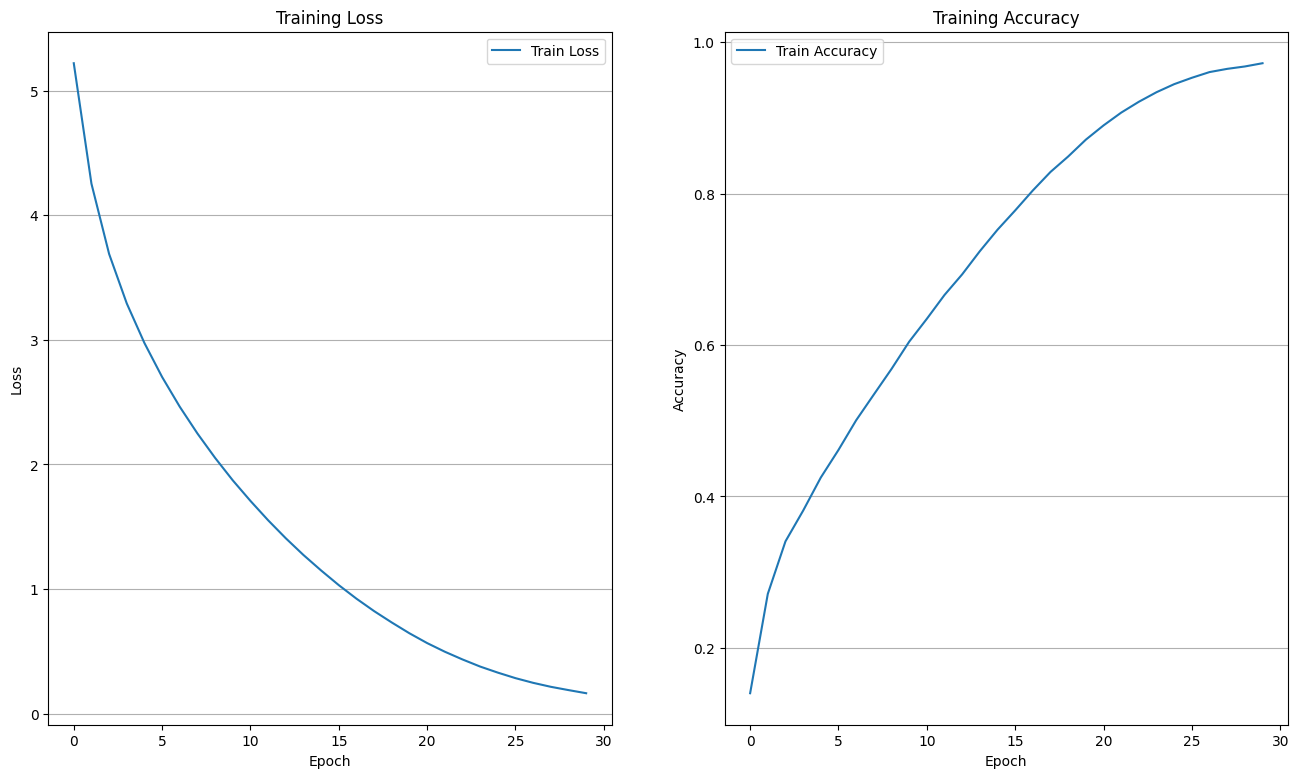

In [10]:
train_model(model, learning_rate, num_epochs, train_loader)

Jak można zaobserwować na powyższych wykresach funkcja straty spada, a skuteczność na zbiorze treningowym rośnie wykładniczo wraz z biegiem treningu. Po 30 epokach uzyskano skuteczność na poziomie 97.22%

### Ewaluacja modelu

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, accuracy_score

def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x)
            _, predicted = torch.max(pred, 1)
            true_labels.extend(y.tolist())
            predicted_labels.extend(predicted.tolist())
    cm = confusion_matrix(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

evaluate_model(model, test_loader)


Confusion Matrix:
[[ 41   0   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...  12   3   1]
 [  1   0   0 ...   4 117   2]
 [  0   0   0 ...   0   4  21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.59        72
           4       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          13       0.50      0.57      0.53         7
          14       1.00      1.00      1.00         1
          15       0.57      1.00      0.73         4
          20       0.00      0.00      0.00         1
          22       1.00      0.75      0.86         4
          28       1.00      1.00      1.00         1
          29       0.00      0.00      0.00         1
          33       1.00      0.50      0.67         2
          40       0.50      0.67      0.57         3
          

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\myenv\Lib\sit

Model bez żadnego finetuningu lub grid searchu uzyskał skuteczność na poziomie 70% na zbiorze testowym, co wskazuje na lekkie przetrenowanie. Niektóre klasy (słowa) były przewidywane niemal bezbłędnie. Wynika to najprawdopodobniej z rozmiaru oraz niewielkiego poziomu zrożnicowania/skomplikowania zbioru danych.

### Przykładowe predykcje

In [12]:
def predict_and_print(model, test_loader, word_to_idx):
    model.eval()
    for input_seq, targets in test_loader:
        for i in range(len(input_seq)):
            input_sentence = [word for idx in input_seq[i] for word, word_idx in word_to_idx.items() if idx == word_idx]
            target_word = [word for word, word_idx in word_to_idx.items() if targets[i].item() == word_idx][0]
            input_seq_tensor = torch.tensor(input_seq[i]).unsqueeze(0)
            with torch.no_grad():
                output_probs = torch.softmax(model(input_seq_tensor), dim = 1)
            _, predicted_index = torch.max(output_probs, 1)
            predicted_word = [word for word, idx in word_to_idx.items() if idx == predicted_index.item()][0]
            print(f"Sentence: {' '.join(input_sentence)}")
            print(f'Target: {target_word}')
            print(f'Prediction: {predicted_word}')
            print()
            if i == 9:
                break
        break

In [13]:
predict_and_print(model, test_loader, word_to_idx)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_23556\1033572604.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_tensor = torch.tensor(input_seq[i]).unsqueeze(0)


Sentence: and understanding life s mosaic crafted from the fragments of
Target: experiences
Prediction: experiences

Sentence: adversities and challenges life s garden flourishes when tended with
Target: the
Prediction: the

Sentence: anchor in the storms of life depend on your wisdom
Target: and
Prediction: and

Sentence: a force for good believe in yourself for you are
Target: capable
Prediction: capable

Sentence: of your story for they encapsulate the chapters of your
Target: growth
Prediction: journey

Sentence: savor each moment as a precious drop in the river
Target: of
Prediction: of

Sentence: dreams dance through the canvas of adventure exploring the uncharted
Target: territories
Prediction: territories

Sentence: our hopes and dreams life s symphony is the music
Target: that
Prediction: of

Sentence: your presence be the gift that makes someone s day
Target: brighter
Prediction: leaving

Sentence: authenticity revealing the spectrum of your uniqueness dance through the
Targe